<a href="https://colab.research.google.com/github/TanZz9/LearnPyTorch/blob/main/1_PyTorchWorkflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow
1. data (prepare or load)
2. build model
3. fitting the model to data(training)
4. making predicitions and evaluting a model
5. saving and loading a model
6. putting it all together


In [5]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
torch.__version__

'2.1.0+cu121'

## 1. Data(preparing or loading)

### Use linear regression formula to make a straight line with known parameters

In [6]:
# create known parameters
weight = 0.7
bias = 0.3

# create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # X's size is 50*1
y = weight * X + bias
X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting the data into training and testing sets

In [7]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(X_test)

(40, 10)

### Visualize the data

In [8]:
def plot_prediction(train_data=X_train,
                    train_label=y_train,
                    test_data=X_test,
                    test_label=y_test,
                    prediction=None):
  plt.figure(figsize=(10, 7))

  # plot the training data in blue
  plt.scatter(train_data, train_label, c="b", s=4, label="Training Data")

  # plot the testing data in green
  plt.scatter(test_data, test_label, c="g", s=4, label="Testing data")

  if prediction is not None:
    # plot the prediction if they exist
    plt.scatter(test_data, prediction, c="r", s=4, label="Prediction")

  plt.legend(prop={"size":14})

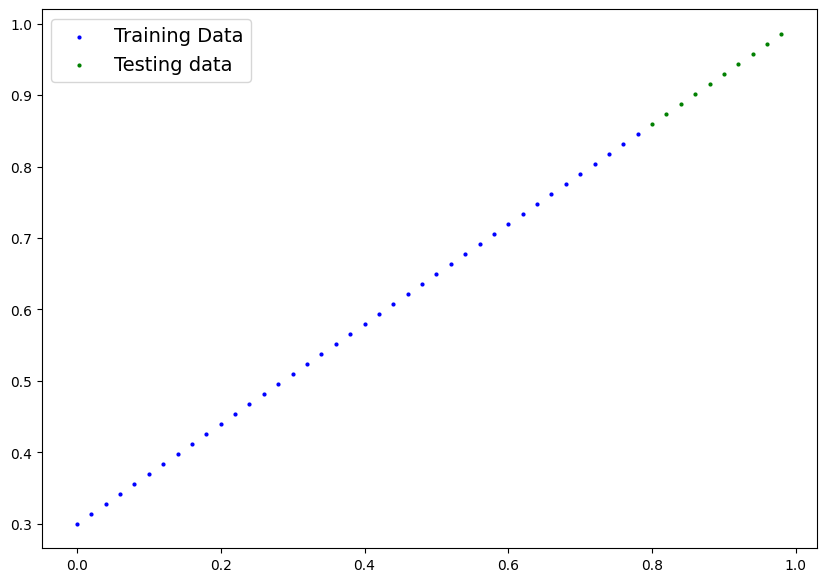

In [9]:
plot_prediction()

## Module
* Start with random values
* Look at training data and adjust the random values to better represent (or get closed to) the ideal values

How does it do so?

Through two main alagorithm:
1. Gradient descent
2. Backpropagation

In [10]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias # linear regression formula


In [11]:
torch.manual_seed(100)
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3607], requires_grad=True),
 Parameter containing:
 tensor([-0.2859], requires_grad=True)]

In [12]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3607])), ('bias', tensor([-0.2859]))])

In [13]:
# make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds, y_test

(tensor([[0.0026],
         [0.0098],
         [0.0170],
         [0.0242],
         [0.0315],
         [0.0387],
         [0.0459],
         [0.0531],
         [0.0603],
         [0.0675]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

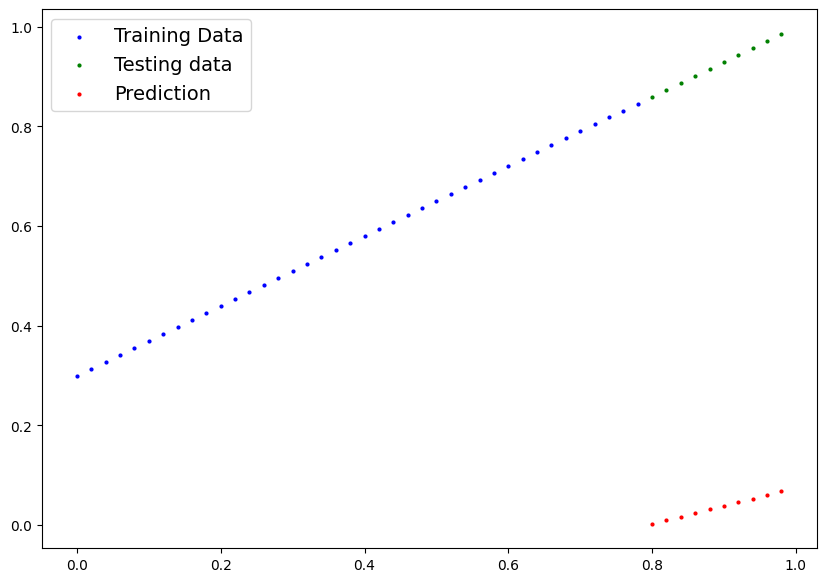

In [14]:
plot_prediction(prediction=y_preds)

## Train model
From a poor representation of the data to a better representation

One way to measure how poor or how wrong your models predictions are is to use a loss function(cost function or criterion).

**Loss Function**: A function to measure how wrong your models' prediction are to the ideal outputs, lower is better.

**Optimizer:** Takes into account the loss of a model and adjusts the model's parameters(e.g. weight & bias)

In [15]:
model_0.state_dict()["weights"]

tensor([0.3607])

In [16]:
# Setup a Loss funciton
loss_fn = nn.L1Loss()

# Setup a optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.001,
                            ) # stochastic gradient descent

### Build a training loop and testing loop in PyTorch

A couple of things:
0. Loop through the data
1. Forward pass (this involves data moving through our model's forward()) to make predictions - also called forward propagation
2. calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our models with respect to the loss(**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss(**gradient descent**)

In [17]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3607], requires_grad=True),
 Parameter containing:
 tensor([-0.2859], requires_grad=True)]

In [18]:
with torch.no_grad():
  print(list(model_0.parameters()))

[Parameter containing:
tensor([0.3607], requires_grad=True), Parameter containing:
tensor([-0.2859], requires_grad=True)]


In [19]:
epoch_count = []
loss_values = []
test_loss_values = []
# An epoch is one loop through the data...
epochs = 2000

# loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train()

  # 1. Forward pass on train data using the forward() method inside
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  # print(f"loss: {loss}")

  # 3. Optimizer zero grad (they accumulate by default)
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (gradient descent)
  optimizer.step()

  # turn off the gradient tracking
  # Testing mode
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_preds = model_0(X_test)

    # 2. Calculate the test loss
    test_loss = loss_fn(test_preds, y_test)

    if epoch % 50 == 0:
      print(f"Epoch: {epoch} | loss: {loss} | Test loss: {test_loss}")

      # print out model state_dict()
      print(model_0.state_dict())

      epoch_count.append(epoch)
      loss_values.append(loss)
      test_loss_values.append(test_loss)

Epoch: 0 | loss: 0.7182652950286865 | Test loss: 0.8865903615951538
OrderedDict([('weights', tensor([0.3610])), ('bias', tensor([-0.2849]))])
Epoch: 50 | loss: 0.660660982131958 | Test loss: 0.8192359805107117
OrderedDict([('weights', tensor([0.3805])), ('bias', tensor([-0.2349]))])
Epoch: 100 | loss: 0.6030559539794922 | Test loss: 0.7518813014030457
OrderedDict([('weights', tensor([0.4000])), ('bias', tensor([-0.1849]))])
Epoch: 150 | loss: 0.5454509854316711 | Test loss: 0.6845265030860901
OrderedDict([('weights', tensor([0.4195])), ('bias', tensor([-0.1349]))])
Epoch: 200 | loss: 0.4878459870815277 | Test loss: 0.6171716451644897
OrderedDict([('weights', tensor([0.4390])), ('bias', tensor([-0.0849]))])
Epoch: 250 | loss: 0.4302411675453186 | Test loss: 0.5498169660568237
OrderedDict([('weights', tensor([0.4585])), ('bias', tensor([-0.0349]))])
Epoch: 300 | loss: 0.37263625860214233 | Test loss: 0.4824622571468353
OrderedDict([('weights', tensor([0.4780])), ('bias', tensor([0.0151])

In [20]:
import numpy as np
epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), np.array(torch.tensor(test_loss_values).cpu().numpy())

([0,
  50,
  100,
  150,
  200,
  250,
  300,
  350,
  400,
  450,
  500,
  550,
  600,
  650,
  700,
  750,
  800,
  850,
  900,
  950,
  1000,
  1050,
  1100,
  1150,
  1200,
  1250,
  1300,
  1350,
  1400,
  1450,
  1500,
  1550,
  1600,
  1650,
  1700,
  1750,
  1800,
  1850,
  1900,
  1950],
 array([7.1826530e-01, 6.6066098e-01, 6.0305595e-01, 5.4545099e-01,
        4.8784599e-01, 4.3024117e-01, 3.7263626e-01, 3.1503147e-01,
        2.5742647e-01, 1.9982152e-01, 1.4221653e-01, 8.4611803e-02,
        3.1251188e-02, 1.8271789e-02, 1.5863674e-02, 1.4118600e-02,
        1.2399031e-02, 1.0681381e-02, 8.9638662e-03, 7.2469055e-03,
        5.5292966e-03, 3.8124353e-03, 2.0947880e-03, 3.7796423e-04,
        4.4334232e-04, 4.4334232e-04, 4.4334232e-04, 4.4334232e-04,
        4.4334232e-04, 4.4334232e-04, 4.4334232e-04, 4.4334232e-04,
        4.4334232e-04, 4.4334232e-04, 4.4334232e-04, 4.4334232e-04,
        4.4334232e-04, 4.4334232e-04, 4.4334232e-04, 4.4334232e-04],
       dtype=float32)

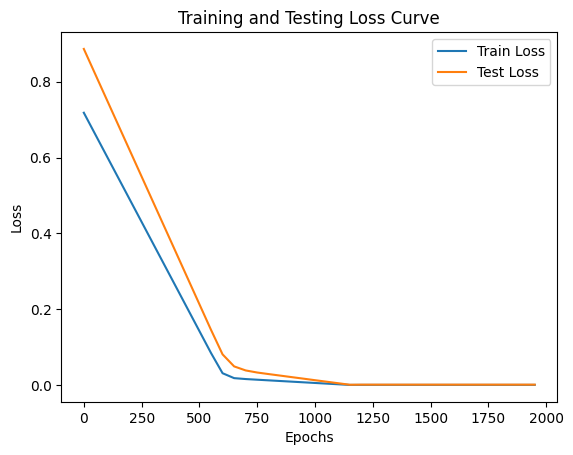

In [21]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label="Train Loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).cpu().numpy()), label="Test Loss")
plt.title("Training and Testing Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [22]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.6996], requires_grad=True),
 Parameter containing:
 tensor([0.3006], requires_grad=True)]

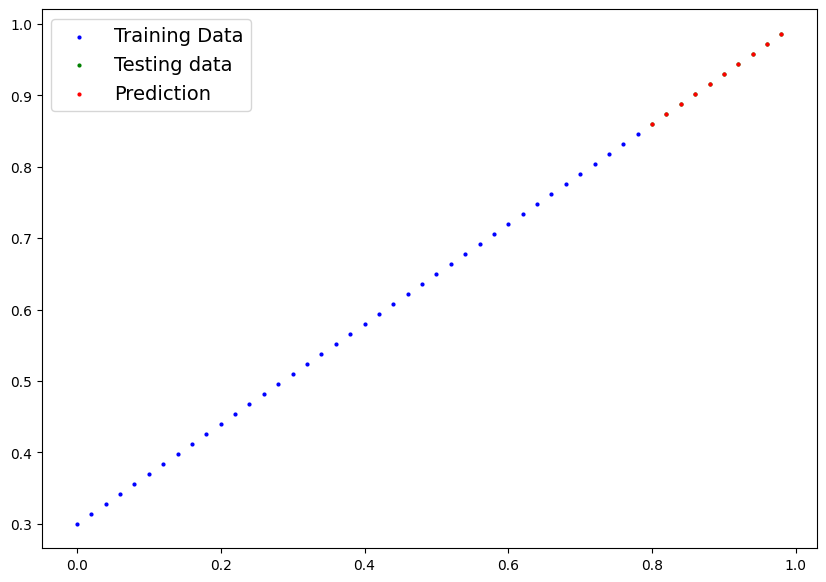

In [23]:
with torch.inference_mode():
  y_preds = model_0(X_test)

plot_prediction(prediction=y_preds)

## Save / Load a model

1. torch.save()
2. torch.load()
3. torch.nn.Module.load_state_dict() - this allows you to load a model's saved state dictionary

In [24]:
from pathlib import Path

# Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
torch.save(model_0, MODEL_SAVE_PATH)

In [25]:
# To load in a saved model state dict we have to instantiate a new instance of our model class
load_model_0 = LinearRegressionModel()

load_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH).state_dict())

<All keys matched successfully>

In [26]:
load_model_0.state_dict()

OrderedDict([('weights', tensor([0.6996])), ('bias', tensor([0.3006]))])

## Putting it all together

In [27]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [28]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 1. Data

In [29]:
weight = 0.7
bias = 0.3


start = 0
end = 1
step = 0.02

# create features and labels
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = X * weight + bias

train_split = int(len(X) * 0.8)

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(X_test)

(40, 10)

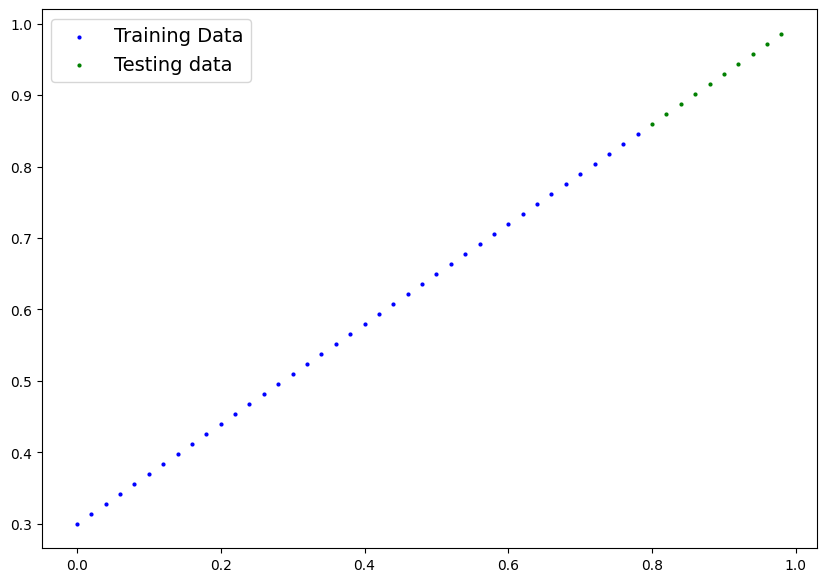

In [30]:
plot_prediction(X_train, y_train, X_test, y_test)

### 2. Linear Model

In [31]:
# Create a Linear Model by nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(100)
model_1 = LinearRegressionModelV2()
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.7767]])),
             ('linear_layer.bias', tensor([0.6317]))])

In [32]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 3. Training

In [33]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [34]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device) # put the data to the same device as the model

torch.manual_seed(100)
epochs = 1000
epoch_count = []
loss_values = []
test_loss_values = []


for epoch in range(epochs):
  model_1.train()

  y_preds = model_1(X_train)

  loss = loss_fn(y_train, y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_preds = model_1(X_test)
    test_loss = loss_fn(y_test, test_preds)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)


Epoch: 0 | Loss: 0.3457670509815216 | Test Loss: 0.9756677746772766
Epoch: 10 | Loss: 0.32158470153808594 | Test Loss: 0.9104726910591125
Epoch: 20 | Loss: 0.3033110797405243 | Test Loss: 0.8544949889183044
Epoch: 30 | Loss: 0.28965863585472107 | Test Loss: 0.8060306906700134
Epoch: 40 | Loss: 0.2791455388069153 | Test Loss: 0.7645705938339233
Epoch: 50 | Loss: 0.27070310711860657 | Test Loss: 0.7282671332359314
Epoch: 60 | Loss: 0.26408621668815613 | Test Loss: 0.6971742510795593
Epoch: 70 | Loss: 0.2585795223712921 | Test Loss: 0.6713628172874451
Epoch: 80 | Loss: 0.2535334527492523 | Test Loss: 0.6468715667724609
Epoch: 90 | Loss: 0.2492583990097046 | Test Loss: 0.6277335286140442
Epoch: 100 | Loss: 0.24525848031044006 | Test Loss: 0.6099337935447693
Epoch: 110 | Loss: 0.24125853180885315 | Test Loss: 0.5921339988708496
Epoch: 120 | Loss: 0.2375829964876175 | Test Loss: 0.5790802240371704
Epoch: 130 | Loss: 0.23409298062324524 | Test Loss: 0.5680603981018066
Epoch: 140 | Loss: 0.230

In [35]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6971]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3077], device='cuda:0'))])

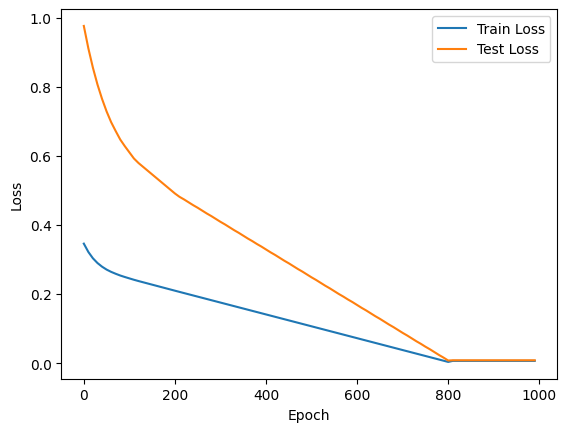

In [36]:
plt.plot(epoch_count, torch.tensor(loss_values).cpu().numpy(), label="Train Loss")
plt.plot(epoch_count, torch.tensor(test_loss_values).cpu().numpy(), label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

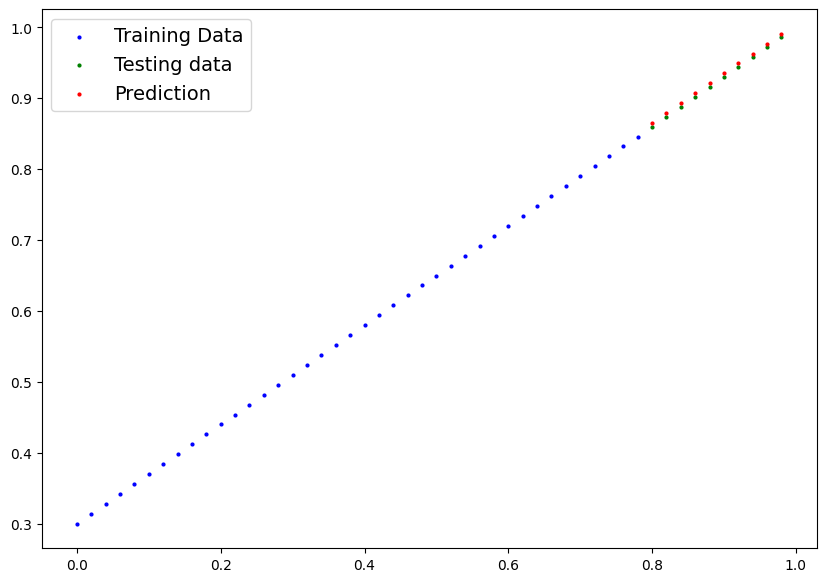

In [37]:
plot_prediction(prediction=model_1(X_test).cpu().detach())

In [38]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_save_path = model_path / "01_pytorch_workflow_model_1.pth"

torch.save(model_1.state_dict(), model_save_path)

In [39]:
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [40]:
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [43]:
loaded_model_1.eval()
model_1.eval()
with torch.inference_mode():
  preds = loaded_model_1(X_test)
  ori_preds = model_1(X_test)

preds == ori_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')